In [1]:
import numpy as np
import pandas as pd
import os
import sys
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
sys.path.insert(0, './')

In [2]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 150

# Magnetic susceptibility 

In this script, I will compute the magnetic susceptibility of the 18,82 $\mu m$ microparticles.

In [3]:
directory= "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/Magnetic_susceptibility/18,82um_MPs/21-12-2022"

filenames = [file for file in glob.glob(
    os.path.join(directory,('*_trj.dat')))]
filenames

['/media/Carol/Magnetic/Experiments/Microfluidics_experiments/Magnetic_susceptibility/18,82um_MPs/21-12-2022/Suceptibility_Bcte_3V_20x-objective_2022_12_21_12_20_13_trj.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/Magnetic_susceptibility/18,82um_MPs/21-12-2022/Suceptibility_Bcte_3V_20x-objective_2022_12_21_12_12_09_trj.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/Magnetic_susceptibility/18,82um_MPs/21-12-2022/Suceptibility_Bcte_3V_20x-objective_2022_12_21_12_18_12_trj.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/Magnetic_susceptibility/18,82um_MPs/21-12-2022/Suceptibility_Bcte_3V_2022_12_21_12_09_45_trj.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/Magnetic_susceptibility/18,82um_MPs/21-12-2022/Suceptibility_Bcte_3V_20x-objective_2022_12_21_12_16_31_trj.dat']

In [4]:
def separation(df):
    
    r = []
    t = []
    n_particles = 2
    for a in range(df.index.get_level_values('frame').max()):
        for i in range(0,n_particles-1):
            for j in range(i+1,n_particles):
                # The factor 0.5862 is to change the units from pix to um then we change the units to m
                r.append(((np.sqrt((df.loc[(a, i), 'x']-df.loc[(a, j), 'x'])**2+
#                                    (df.loc[(a, i), 'y']-df.loc[(a, j), 'y'])**2))/0.5862)/(10**6)) 
                                    (df.loc[(a, i), 'y']-df.loc[(a, j), 'y'])**2))*0.5862*(10**-6))) 
                t.append(a/30)
    
    return r, t 

In [5]:
trj0 = pd.read_csv(filenames[0], index_col = [0,1], sep ="\t")
trj1 = pd.read_csv(filenames[1], index_col = [0,1], sep ="\t")
trj2 = pd.read_csv(filenames[2], index_col = [0,1], sep ="\t")
trj3 = pd.read_csv(filenames[3], index_col = [0,1], sep ="\t")
trj4 = pd.read_csv(filenames[4], index_col = [0,1], sep ="\t")

In [6]:
r0, t0 = separation(trj0)
r1, t1 = separation(trj1)
r2, t2 = separation(trj2)
r3, t3 = separation(trj3)
r4, t4 = separation(trj4)

In [7]:
s0 = pd.Series(r0, name='Video0')
s1 = pd.Series(r1, name='Video1')
s2 = pd.Series(r2, name='Video2')
s3 = pd.Series(r3, name='Video3')
s4 = pd.Series(r4, name='Video4')



df = pd.concat([s0,s1,s2,s3,s4], axis = 1)
df.index.name = "frame"
df.head(5)


,Video0,Video1,Video2,Video3,Video4
frame,,,,,
0,0.000019,0.000019,0.000019,0.00002,0.00002
1,0.000019,0.000019,0.000019,0.00002,0.00002
2,0.000019,0.000019,0.000019,0.00002,0.00002
3,0.000019,0.000019,0.000019,0.00002,0.00002
4,0.000019,0.000019,0.000019,0.00002,0.00002


In [8]:
df['mean'] = df.mean(axis = 1, skipna = True)
df['err'] = df.std(axis = 1)/np.sqrt(df.count(axis = 1).values)

In [9]:
df['time']  = (df.index.get_level_values('frame')/30)

In [10]:
data = df

Text(0, 0.5, 'separation d(t) m')

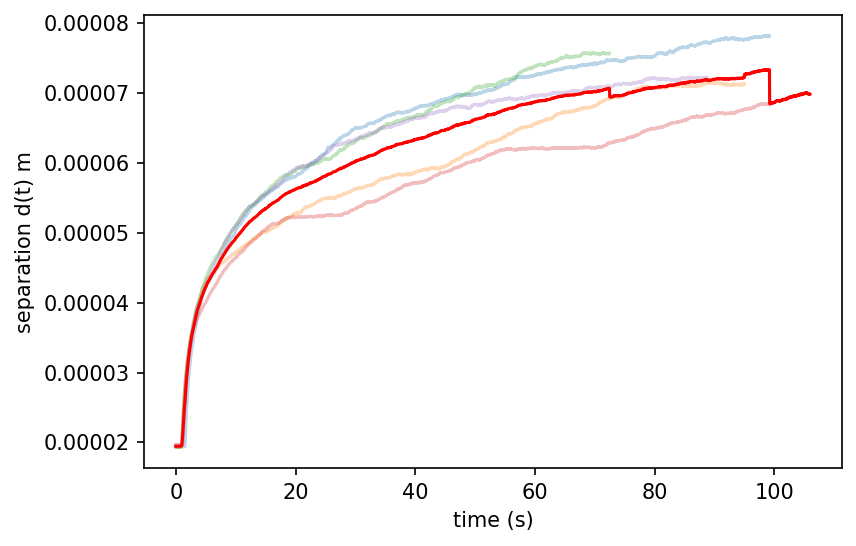

In [11]:
plt.plot(t0,r0, alpha = 0.3)
plt.plot(t1,r1, alpha = 0.3)
plt.plot(t2,r2, alpha = 0.3)
plt.plot(t3,r3, alpha = 0.3)
plt.plot(t4,r4, alpha = 0.3)
plt.plot(data['time'], data['mean'], '-', c = 'red')

plt.xlabel('time (s)')
plt.ylabel('separation d(t) m')

In [12]:
def func (x , A):
    
    a = (18.82/2)/(10**6) #Particle radius in m
    H = 16711 # Magnetic field value in A/m 
    mu = 4*np.pi*10**(-7) # H/m
    eta = 10**(-3) #Pa·s

    C = (5*(H**2)*mu)/(36*eta) # 1/s
    
    y =2*a*(1+(A**2*C*x))**(1/5)

    return y

In [20]:
(2**6)/2**2

16.0

In [22]:
2**4

16

In [13]:
popt, pcov = curve_fit(func, data['time'], data['mean'], method = 'dogbox')
popt, pcov

(array([0.01421778]), array([[4.72321489e-10]]))

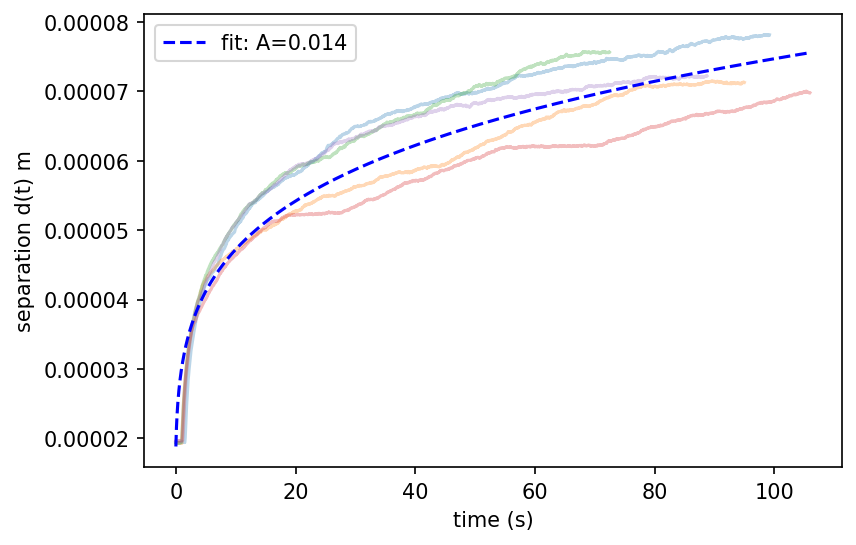

In [14]:
plt.plot(t0,r0, alpha = 0.3)
plt.plot(t1,r1, alpha = 0.3)
plt.plot(t2,r2, alpha = 0.3)
plt.plot(t3,r3, alpha = 0.3)
plt.plot(t4,r4, alpha = 0.3)

plt.xlabel('time (s)')
plt.ylabel('separation d(t) m')


plt.plot(data['time'], func(data['time'], *popt), 'g--',label='fit: A=%5.3f' % tuple(popt), c = 'blue')

plt.legend()


In [24]:
def magnetic_mom(B, r, susceptibility): 
    # Input parameters:  Magnetic field in A/m , radius in m , magnetic susceptibility.
    
    V = (4/3)*np.pi*r**3
    mu = 4*np.pi*10**(-7) # in H/m
    m = (V*B*susceptibility)/mu
    
    return m 

In [30]:
def Dipol_inter(x, m):
    
    mu = 4*np.pi*10**(-7) # in H/m
    
    y = mu*m**2*(4*np.pi*x**3)
    
    return y 

In [31]:
m = magnetic_mom( B = 16711, r =(18.82/2)/(10**6), susceptibility = 0.014)

In [32]:
Dipol_inter(1.9*10**(-5),m)

4.5733739301616596e-32

In [39]:
Dipol_inter(3.0*10**(-5),m)

1.8002784095985543e-31

#  